In [2]:
from torch import optim
from  torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch
import helper
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
batch_size = 128
# Download and load the training data
train_set = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
test_set = datasets.MNIST('MNIST_data/',download=True,train=False,transform=transform)

num_works = 0
valid_split = 0.5
#把test数据集分成test和valid
num_test = len(test_set)#得到数据大小
indices = list(range(num_test))#得到下表索引值列表
#np.random.shuffle(indices)

split = int(np.floor(valid_split*num_test))# 返回不大于输入参数的最大整数。 即对于输入值 x ，将返回最大的整数 i ，使得 i <= x
test_idx,valid_idx = indices[split:],indices[:split] #返回所需的元素索引列表

test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_idx) #样本元素从指定的索引列表中随机抽取，没有替换。参数： - indices (list) – 索引的列表
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False,num_workers=num_works)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False,sampler=test_sampler,num_workers=num_works)
valid_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False,sampler=valid_sampler,num_workers=num_works)

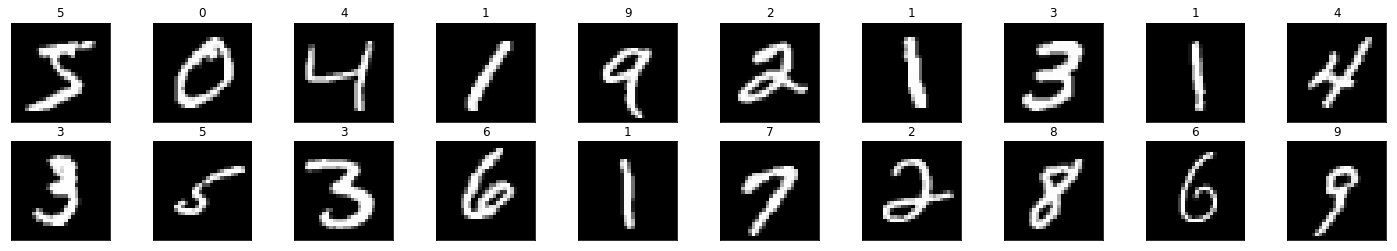

In [3]:
dataiter = iter(train_loader)
images,labels = dataiter.next()

images = images.numpy()

fig = plt.figure(figsize=(25,4),facecolor='white')

for idx in np.arange(20):
    ax = fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(images[idx]),cmap='gray')
    ax.set_title(str(labels[idx].item()))



In [119]:
#更仔细地查看图像
dataiter = iter(train_loader)
images,labels = dataiter.next()

images = images.numpy()
img = np.squeeze(images[0])

fig = plt.figure(figsize=(12,12))
ax.imshow(img,cmap='gray')
width,height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] != 0 else 0
        ax.annotate(str(val),xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color ='white' if img[x][y]<thresh else 'black')
        ax.imshow(img,cmap='gray')

In [4]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(LSTM, self).__init__()
        
        self.hidden_dim=hidden_dim
        self.n_layers = n_layers
        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers,dropout=0, batch_first=True)
        
        # last, fully-connected layer
        self.fc1 = nn.Linear(hidden_dim,hidden_dim*2)
        self.fc = nn.Linear(hidden_dim*2, output_size)
        self.fc2 = nn.Linear(hidden_dim,output_size)
      #  self.softmax = nn.Softmax(dim=1)
    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.lstm(x, hidden)
        """
        r_out = torch.mean(r_out,dim=2).squeeze()
        
        output= self.fc2(r_out)
        # shape output to be (batch_size*seq_length, hidden_dim)
        """
        r_out = r_out.contiguous().view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc2(r_out)
       # output = self.fc(output)
        output = output.view(batch_size,-1,10)
        output = output[:,-1]
      #  output = self.softmax(output)
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if use_cuda:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden

use_cuda = torch.cuda.is_available()

In [5]:
def train(model,epochs,train_loader,valid_loader,lr=0.03):
    train_losses_e =[]
    valid_losses_e =[]
    accuracies_e = []
    loss_min = np.inf
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for e in range(epochs):
        running_loss = 0
        train_losses =[]
        valid_losses =[]
        accuracies = []
        for images,labels in train_loader:
            # Flatten MNIST images into a 784 long vector
            
            images = images.squeeze()
            h = model.init_hidden(images.shape[0])
            h = tuple([each.data for each in h])
            
            if use_cuda:
                images,labels = images.cuda(),labels.cuda()
            optimizer.zero_grad()
            # TODO: Training pass
            output ,h= model(images,h)
            
            loss = criterion(output, labels)
            # print(loss)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        model.eval()
        for images,labels in valid_loader:
            images = images.squeeze()
            h = model.init_hidden(images.shape[0])
            h = tuple([each.data for each in h])
            
            if use_cuda:
                images,labels = images.cuda(),labels.cuda()
            out,h = model(images,h)
            valid_loss = criterion(out,labels)
            _,index = out.topk(1,dim=1)
            eq = index == labels.view(index.shape)
            accuracy = torch.mean(eq.type(torch.FloatTensor)).item()
            valid_losses.append(valid_loss.item())
            accuracies.append(accuracy)
        train_losses_e.append(np.mean(train_losses))
        valid_losses_e.append(np.mean(valid_losses))
        accuracies_e.append(np.mean(accuracies))
        print(e+1,"/",epochs,"Training loss: {},Valid_loss:{},Valid_accuracy:{}".format(np.mean(train_losses),np.mean(valid_losses),np.mean(accuracies)))
        if loss_min > np.mean(valid_losses):     
            print('Loss decrease...')
            loss_min = np.mean(valid_losses)
            torch.save(model.state_dict(),'model/net_mnist_loss_min_lstm_old.pth')
            
        
        model.train()
    print('min loss:',loss_min)
    plt.plot(train_losses_e,color='r',label='train_loss')
    plt.plot(valid_losses_e,color='g',label='valid_loss')
    plt.title('Loss_Trend')
    plt.xlabel('Epoches')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('image/loss_lstm_old.svg')
    return  accuracies_e

1 / 60 Training loss: 0.7980304150693198,Valid_loss:0.3792056512087584,Valid_accuracy:0.8767578125
Loss decrease...
2 / 60 Training loss: 0.21863662504724093,Valid_loss:0.20454031452536584,Valid_accuracy:0.933203125
Loss decrease...
3 / 60 Training loss: 0.14655712858509662,Valid_loss:0.1940183939412236,Valid_accuracy:0.934765625
Loss decrease...
4 / 60 Training loss: 0.10972486396254634,Valid_loss:0.17778507247567177,Valid_accuracy:0.9419921875
Loss decrease...
5 / 60 Training loss: 0.08505743270171985,Valid_loss:0.14578244872391224,Valid_accuracy:0.955859375
Loss decrease...
6 / 60 Training loss: 0.06852577318514842,Valid_loss:0.11650055376812815,Valid_accuracy:0.9640625
Loss decrease...
7 / 60 Training loss: 0.05714223409957215,Valid_loss:0.11833555679768323,Valid_accuracy:0.96171875
8 / 60 Training loss: 0.048675599946840994,Valid_loss:0.10478468062356114,Valid_accuracy:0.96640625
Loss decrease...
9 / 60 Training loss: 0.042205491792291466,Valid_loss:0.12344461153261363,Valid_accur

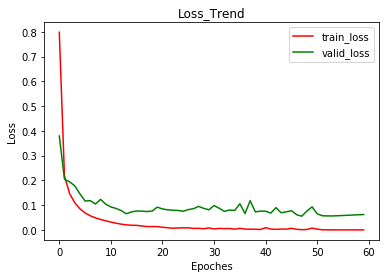

In [6]:
model = LSTM(28,10,512,2) #512,2 0.983  256,2 0.983 ,64 ,2 0.984,32,2,0.983,256,4.0.983
if use_cuda:
    model.cuda()
from time import time
start = time()
accuracy = train(model, 60,train_loader,valid_loader,0.0001)
print('Training Time is:',time()-start,'s')

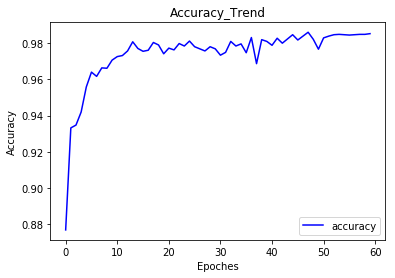

In [7]:
plt.plot(accuracy,color='b',label='accuracy')
plt.title('Accuracy_Trend')
plt.xlabel('Epoches')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('image/accuracy_lstm_old.svg')

In [8]:
def test(net,test_loader):
    criterion = nn.CrossEntropyLoss()
    valid_loss = []
    accuracies_ = []
    class_correct = np.zeros(10)
    class_total = np.zeros(10)
    classes = ['0','1','2','3','4','5','6','7','8','9']
    net.eval()
    for x,y in test_loader:
        x = x.squeeze()
        h = net.init_hidden(x.shape[0])
        h = tuple([each.data for each in h])
        if use_cuda:
            x,y = x.cuda(),y.cuda()
        out,h = net(x,h)
        loss = criterion(out,y)
        _,class_ = torch.max(out,dim=1)
        equal = class_ == y.view(class_.shape)
        for i in range(y.shape[0]):
            label = y.data[i].item()
            class_correct[label] += equal[i].item()
            class_total[label] += 1
        accuracy = torch.mean(equal.type(torch.FloatTensor)).item()
        accuracies_.append(accuracy)
        
        valid_loss.append(loss.item())
    #print('Test Loss: {:.6f}\n'.format(loss.item()))
    for i in range(10):
        if class_total[i]>0:
            print('Test Accuracy of {}:{:.4f}({}/{})'.format(classes[i],100*class_correct[i]/class_total[i],
                 int(np.sum(class_correct[i])),
                 int(np.sum(class_total[i]))))
        else:
            print('Test Accuracy of {}:N/A(no examples)'.format(classes[i]))
    print('Test Accuracy(Overall):{:.4f} ({}/{})'.format(100*np.sum(class_correct)/np.sum(class_total),
                                                    int(np.sum(class_correct)),
                                                    int(np.sum(class_total))))
    print('Test Loss:',np.mean(valid_loss),'Test Accuracy:',np.mean(accuracies_))

In [9]:
model_test = LSTM(28,10,512,2)
if use_cuda:
    model_test.cuda()
model_test.load_state_dict(torch.load('model/net_mnist_loss_min_lstm_old.pth'))
test(model_test,test_loader)

Test Accuracy of 0:99.4231(517/520)
Test Accuracy of 1:99.1135(559/564)
Test Accuracy of 2:99.8008(501/502)
Test Accuracy of 3:99.4118(507/510)
Test Accuracy of 4:99.1701(478/482)
Test Accuracy of 5:99.0826(432/436)
Test Accuracy of 6:100.0000(496/496)
Test Accuracy of 7:99.2248(512/516)
Test Accuracy of 8:99.3814(482/485)
Test Accuracy of 9:99.5910(487/489)
Test Accuracy(Overall):99.4200 (4971/5000)
Test Loss: 0.029482278693467378 Test Accuracy: 0.9943359375
